### About the problem and dataset:

Use NYC's openly available taxi-fare dataset to predict the price of a Taxi ride. Our goal is to use TF as the ML Framework to build a pipeline which should be capable of scaling on infinite data to make an enterprise scale model.

**Dataset**: 
15K records of NYC taxi trip including below signals:
1. pickup_community_area
2. **fare**
3. trip_start_month
4. trip_start_hour
5.   trip_start_day  
6.   trip_start_timestamp
7.   pickup_latitude     
8.   pickup_longitude    
9.   dropoff_latitude    
10.   dropoff_longitude  
11.  trip_miles          
12.  pickup_census_tract 
13.  dropoff_census_tract
14.  payment_type        
15.  company             
16.  trip_seconds        
17.  dropoff_community_area
18.  tips                  


In [ ]:
# Owner - Hasan Rafiq
# Load the TensorBoard notebook extension
%load_ext tensorboard

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import folium

from folium import plugins

import tensorflow as tf
import tensorflow.keras as keras
print(tf.__version__)

device = "gpu"

if device == "tpu":
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.config.experimental_connect_to_cluster(resolver)
  # This is the TPU initialization code that has to be at the beginning.
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver)
else:
  strategy = tf.distribute.MultiWorkerMirroredStrategy()

2.4.1
INFO:tensorflow:Using MirroredStrategy with devices ('/device:GPU:0',)
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0',), communication = CommunicationImplementation.AUTO


### Read From Kaggle

In [ ]:
!pip install kaggle

In [ ]:
cd /root/

/root


In [ ]:
!mkdir .kaggle

In [ ]:
cd /root/.kaggle

/root/.kaggle


In [ ]:
import json
token = {"username":"rridhijain","key":"12722489288ce3cf875d92e6deff9687"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [ ]:
!cp /root/.kaggle/kaggle.json ~/.kaggle/kaggle.json

cp: '/root/.kaggle/kaggle.json' and '/root/.kaggle/kaggle.json' are the same file


In [ ]:
!kaggle config set -n path -v{/root}

- path is now set to: {/root}


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c new-york-city-taxi-fare-prediction -p /root/new-york-city-taxi

100% 1.56G/1.56G [00:08<00:00, 58.6MB/s]
100% 1.56G/1.56G [00:08<00:00, 204MB/s] 
  0% 0.00/486 [00:00<?, ?B/s]
100% 486/486 [00:00<00:00, 488kB/s]
  0% 0.00/335k [00:00<?, ?B/s]
100% 335k/335k [00:00<00:00, 109MB/s]
  0% 0.00/960k [00:00<?, ?B/s]
100% 960k/960k [00:00<00:00, 134MB/s]


In [ ]:
cd /root/new-york-city-taxi

/root/new-york-city-taxi


In [ ]:
!unzip /root/new-york-city-taxi/*.zip

Archive:  /root/new-york-city-taxi/train.csv.zip
  inflating: train.csv               


## Load Dataset

In [ ]:
df = pd.read_csv('/root/new-york-city-taxi/train.csv', nrows=15000)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                15000 non-null  object 
 1   fare_amount        15000 non-null  float64
 2   pickup_datetime    15000 non-null  object 
 3   pickup_longitude   15000 non-null  float64
 4   pickup_latitude    15000 non-null  float64
 5   dropoff_longitude  15000 non-null  float64
 6   dropoff_latitude   15000 non-null  float64
 7   passenger_count    15000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 937.6+ KB


### Data - **Preprocessing**

In [ ]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [ ]:
import datetime

In [ ]:
trip_start_month = []
trip_start_hour = []
trip_start_day = []
for trip_date_time in df['pickup_datetime']:
  trip_date = trip_date_time.split(" ")[0]
  trip_time = trip_date_time.split(" ")[1]
  trip_start_month.append(str(trip_date.split("-")[1]))
  trip_start_hour.append(str(trip_time.split(":")[0]))
  trip_start_date_time = datetime.datetime.strptime(trip_date, '%Y-%m-%d')
  # print(trip_start_date_time)
  trip_start_day.append(str(trip_start_date_time.weekday()))
df['trip_start_month'] = trip_start_month
df['trip_start_hour'] = trip_start_hour
df['trip_start_day'] = trip_start_day

In [ ]:
# df['passenger_count'] = df['passenger_count'].astype(float)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                15000 non-null  object 
 1   fare_amount        15000 non-null  float64
 2   pickup_datetime    15000 non-null  object 
 3   pickup_longitude   15000 non-null  float64
 4   pickup_latitude    15000 non-null  float64
 5   dropoff_longitude  15000 non-null  float64
 6   dropoff_latitude   15000 non-null  float64
 7   passenger_count    15000 non-null  int64  
 8   trip_start_month   15000 non-null  object 
 9   trip_start_hour    15000 non-null  object 
 10  trip_start_day     15000 non-null  object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.3+ MB


In [ ]:
##Get unique count for each column
df.nunique()

key                  15000
fare_amount            449
pickup_datetime      14965
pickup_longitude     12976
pickup_latitude      13396
dropoff_longitude    13093
dropoff_latitude     13416
passenger_count          7
trip_start_month        12
trip_start_hour         24
trip_start_day           7
dtype: int64

In [ ]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,11.280221,-72.458850,39.912346,-72.453446,39.888853,1.640533
std,9.629876,10.599606,6.902040,10.612553,6.239854,1.264472
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992171,40.734728,-73.991186,40.734643,1.000000
50%,8.500000,-73.981697,40.752620,-73.980133,40.753652,1.000000
75%,12.500000,-73.966765,40.767444,-73.963607,40.768094,2.000000
max,180.000000,40.766125,401.083332,40.802437,41.366138,6.000000


In [ ]:
##Drop useless columns
# df = df.drop(['trip_start_timestamp','trip_miles','pickup_census_tract',
#               'dropoff_census_tract','trip_seconds','payment_type','tips', 
#               'company','dropoff_community_area','pickup_community_area'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   key                15000 non-null  object 
 1   fare_amount        15000 non-null  float64
 2   pickup_datetime    15000 non-null  object 
 3   pickup_longitude   15000 non-null  float64
 4   pickup_latitude    15000 non-null  float64
 5   dropoff_longitude  15000 non-null  float64
 6   dropoff_latitude   15000 non-null  float64
 7   passenger_count    15000 non-null  int64  
 8   trip_start_month   15000 non-null  object 
 9   trip_start_hour    15000 non-null  object 
 10  trip_start_day     15000 non-null  object 
dtypes: float64(5), int64(1), object(5)
memory usage: 1.3+ MB


In [ ]:
#Drop NA rows
df = df.dropna()

#Drop rows where FARE > 200( only 1 row found )
df = df.drop(df[df['fare_amount'] > 200].index)

df = df.drop(['pickup_datetime','key', 'passenger_count'], axis=1)

#Change datatype of cols
# df['trip_start_month'] = df['trip_start_month'].astype('str')
# df['trip_start_hour'] = df['trip_start_hour'].astype('str')
# df['trip_start_day'] = df['trip_start_day'].astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        15000 non-null  float64
 1   pickup_longitude   15000 non-null  float64
 2   pickup_latitude    15000 non-null  float64
 3   dropoff_longitude  15000 non-null  float64
 4   dropoff_latitude   15000 non-null  float64
 5   trip_start_month   15000 non-null  object 
 6   trip_start_hour    15000 non-null  object 
 7   trip_start_day     15000 non-null  object 
dtypes: float64(5), object(3)
memory usage: 1.7+ MB


In [ ]:
# ##Train test split ( Original DF )
np.random.seed(seed=2)
msk = np.random.rand(len(df)) < 0.85
traindf = df[msk]
evaldf = df[~msk]

print(len(traindf))
print(len(evaldf))

12745
2255


In [ ]:
traindf

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_start_month,trip_start_hour,trip_start_day
0,4.5,-73.844311,40.721319,-73.841610,40.712278,06,17,0
1,16.9,-74.016048,40.711303,-73.979268,40.782004,01,16,1
2,5.7,-73.982738,40.761270,-73.991242,40.750562,08,00,3
3,7.7,-73.987130,40.733143,-73.991567,40.758092,04,04,5
4,5.3,-73.968095,40.768008,-73.956655,40.783762,03,07,1
...,...,...,...,...,...,...,...,...
14994,6.0,-73.978600,40.744930,-73.991182,40.750237,08,20,0
14995,8.5,-73.995781,40.742569,-73.997551,40.719509,02,19,6
14996,9.7,-73.970910,40.761350,-73.976352,40.744828,03,15,3
14998,6.0,-73.969019,40.761372,-73.980987,40.744484,09,03,5


### Data - **Exploration**

We sample a small amount of training data, which we use for EDA / VDA and feature engineering. The same knowledge will then be applied when we build the model called as **feature engineering**.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


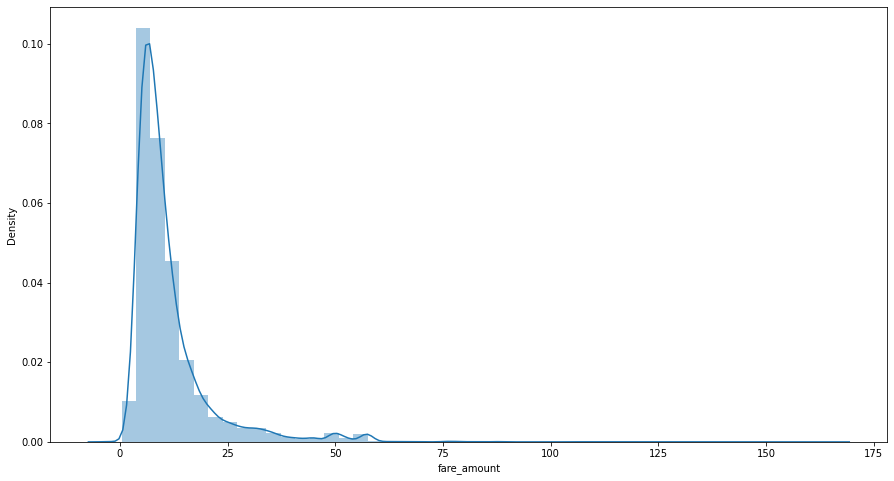

In [ ]:
##Distribution of Fare
plt.figure(figsize=(15, 8))
sns.distplot(traindf['fare_amount'])

In [ ]:
##Plot locations with heatmap intensity as per the FARE
m = folium.Map()
sw = traindf[['pickup_latitude', 'pickup_longitude']].min().values.tolist()
ne = traindf[['pickup_latitude', 'pickup_longitude']].max().values.tolist()
m.add_child(plugins.HeatMap(zip(traindf['pickup_latitude'], traindf['pickup_longitude'], traindf['fare_amount']), radius = 10))
m.fit_bounds([sw, ne])
m

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

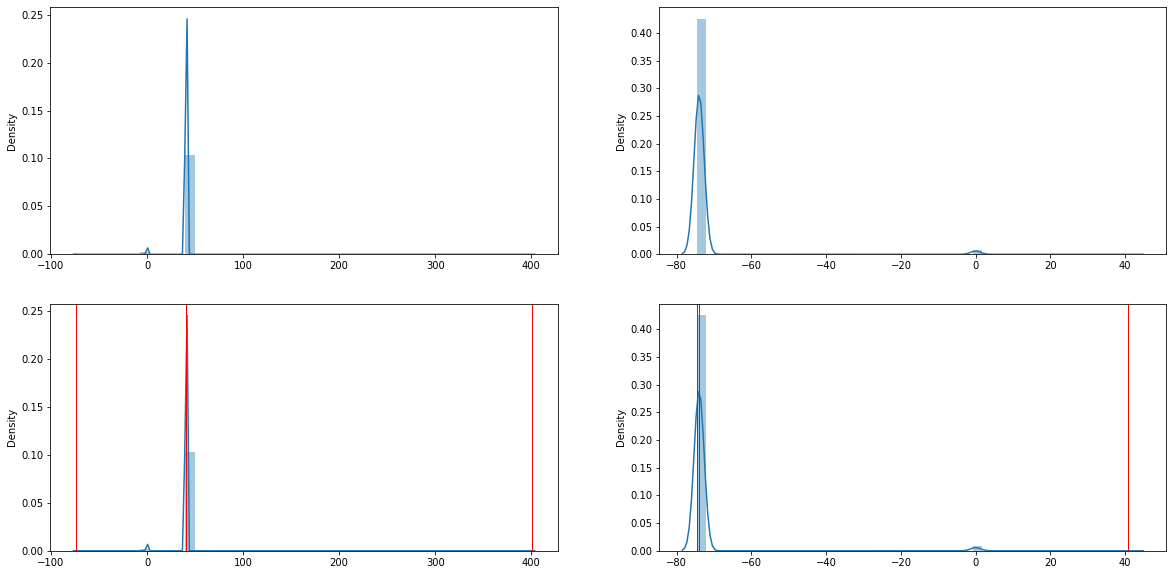

In [ ]:
##Quantile Bucketization of latitude and longitude
# bins_lat = np.linspace(np.min([np.min(df['dropoff_latitude']),np.min(df['pickup_latitude'])]),
#             np.max([np.max(df['dropoff_latitude']),np.max(df['pickup_latitude'])]),
#             20)
bins_lat = pd.qcut(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), q=20, duplicates='drop', retbins=True)[1]

# bins_lon = np.linspace(np.min([np.min(df['dropoff_longitude']),np.min(df['pickup_longitude'])]),
#             np.max([np.max(df['dropoff_longitude']),np.max(df['pickup_longitude'])]),
#             20)
bins_lon = pd.qcut(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), q=20, duplicates='drop', retbins=True)[1]

#Plot all latitude values with bins
f, axes = plt.subplots(2, 2, figsize=(20, 10), sharex=False)
sns.distplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[0, 0])
sns.distplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[0, 1])

#Plot bins
sns.distplot(list(df['dropoff_latitude'].values) + list(df['pickup_latitude'].values), ax=axes[1, 0])
sns.distplot(list(df['dropoff_longitude'].values) + list(df['pickup_longitude'].values), ax=axes[1, 1])
for b_ in bins_lat:
  axes[1][0].axvline(b_, color='red', linewidth=1 )
for b_ in bins_lon:
  axes[1][1].axvline(b_, color='red', linewidth=1 )

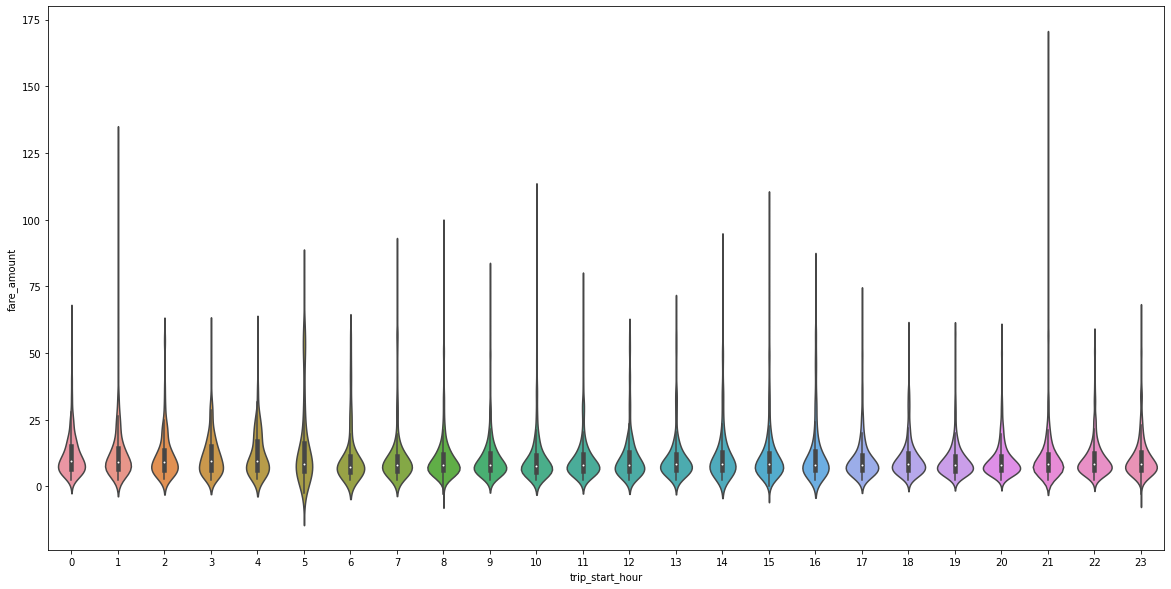

In [ ]:
plt.figure(figsize=(20, 10))
sns.violinplot(x=traindf['trip_start_hour'].astype(int), y=traindf['fare_amount'])

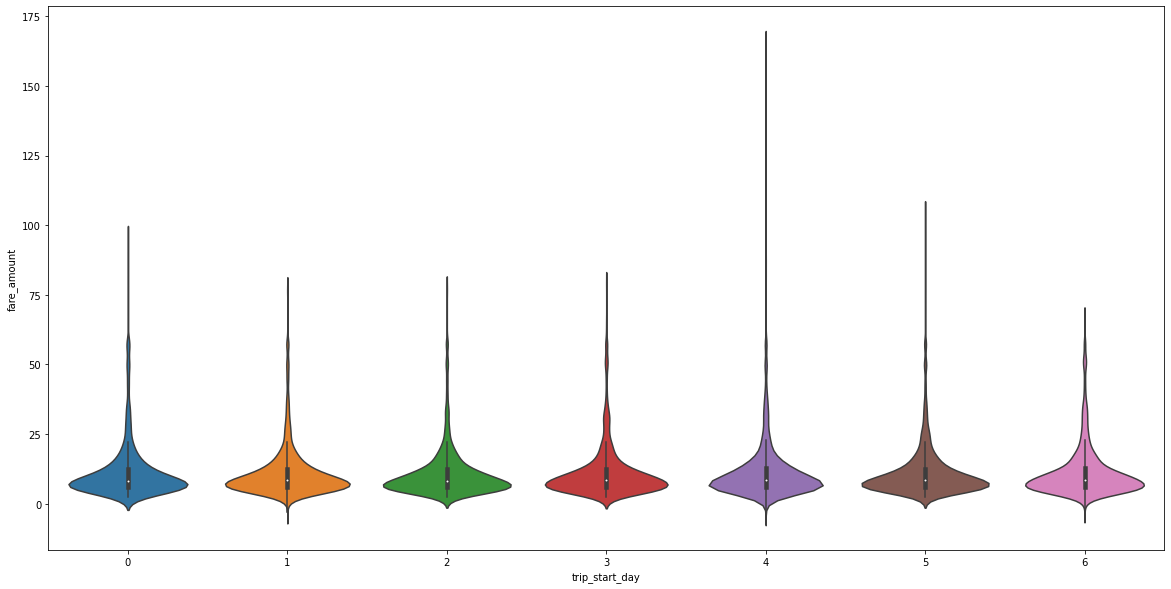

In [ ]:
plt.figure(figsize=(20, 10))
sns.violinplot(x=traindf['trip_start_day'].astype(int), y=traindf['fare_amount'])

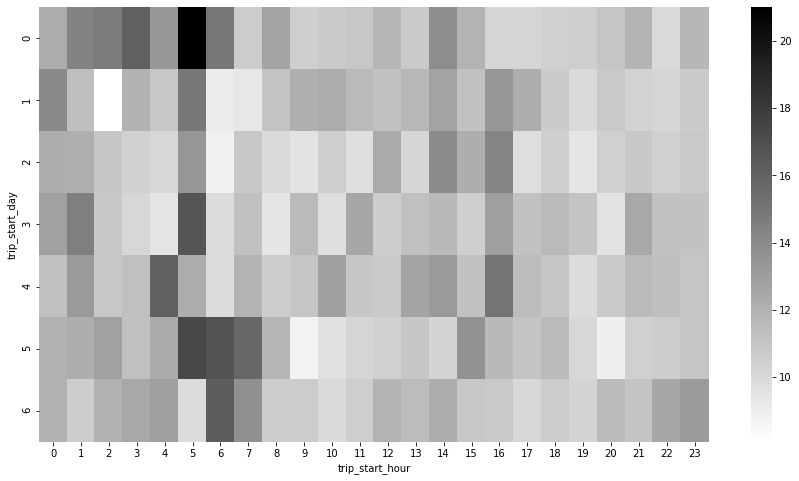

In [ ]:
##Average trip fare( day & hour combined )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf['fare_amount'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

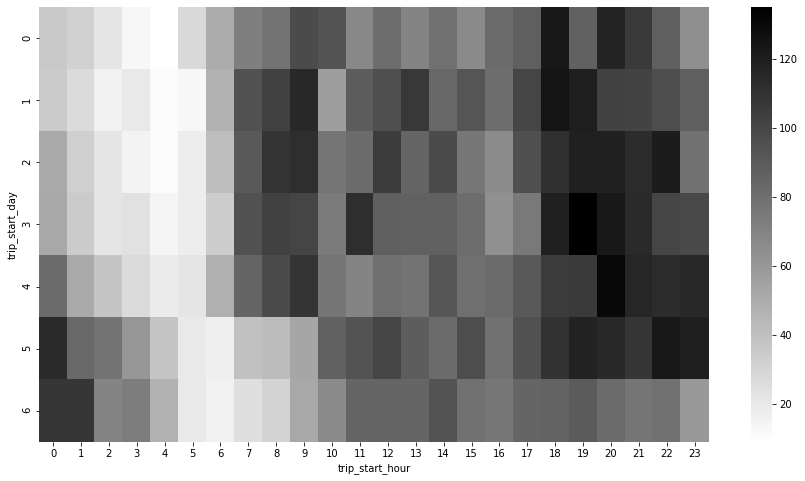

In [ ]:
##Number of trips( day-hour wise )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf.index , aggfunc='count')
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

**Feature engineering exploration**:

Explore possible transformations that can be added as new features in the model to increase accuracy of the model and reduce training time.

In [ ]:
##Calculate Euclidean distance
from scipy.spatial import distance
def euclidean(row):
  # print(row)
  a = (row['pickup_latitude'], row['pickup_longitude'])
  b = (row['dropoff_latitude'], row['dropoff_longitude'])
  row['distance'] = distance.euclidean(a, b) * 100
  return row

traindf = traindf.apply(euclidean, axis=1)
evaldf = evaldf.apply(euclidean, axis=1)
traindf.head()  

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_start_month,trip_start_hour,trip_start_day,distance
0,4.5,-73.844311,40.721319,-73.841610,40.712278,06,17,0,0.943584
1,16.9,-74.016048,40.711303,-73.979268,40.782004,01,16,1,7.969567
2,5.7,-73.982738,40.761270,-73.991242,40.750562,08,00,3,1.367404
3,7.7,-73.987130,40.733143,-73.991567,40.758092,04,04,5,2.534047
4,5.3,-73.968095,40.768008,-73.956655,40.783762,03,07,1,1.946952


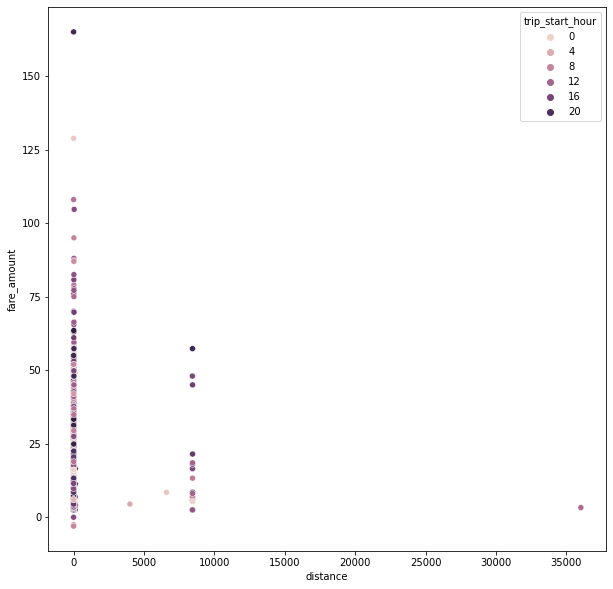

In [ ]:
##Fair Vs distance plot( Colored by Trip Start Hour )
plt.figure(figsize=(10, 10))
sns.scatterplot(x=traindf['distance'], y=traindf['fare_amount'], hue=traindf['trip_start_hour'].astype(int))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


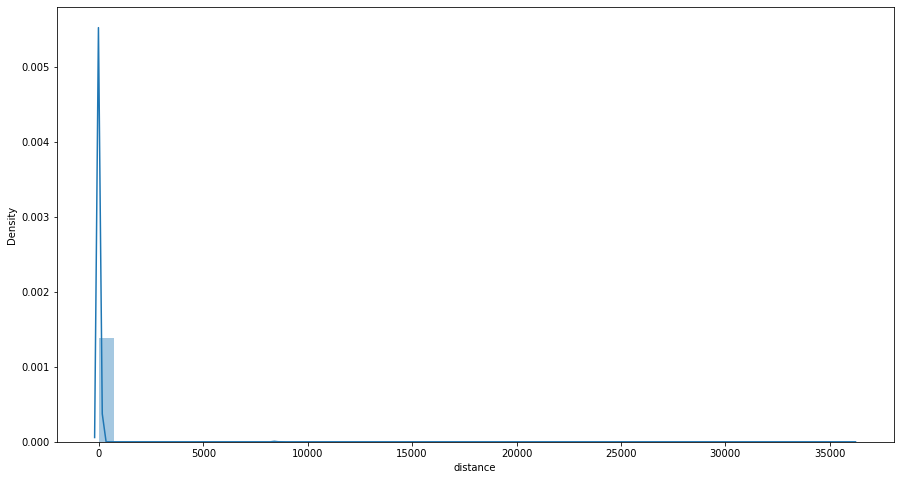

In [ ]:
plt.figure(figsize=(15, 8))
sns.distplot(traindf['distance'])

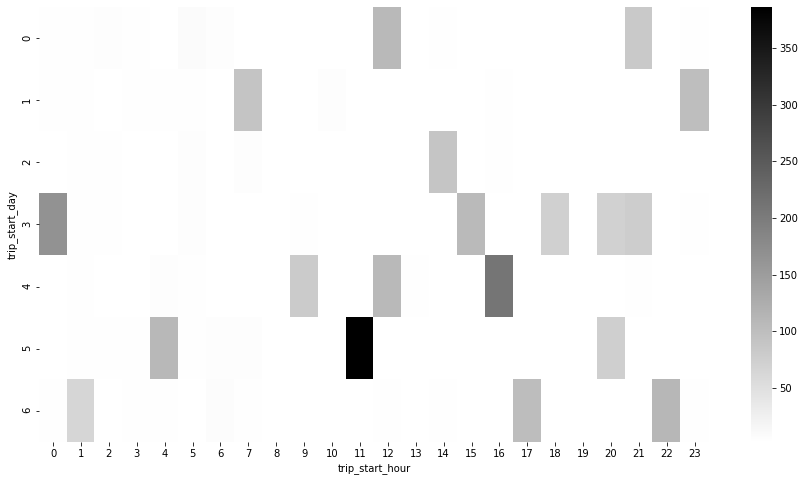

In [ ]:
##Average trip distance( day-hour wise )
plt.figure(figsize=(15, 8))
cross = pd.crosstab(traindf['trip_start_day'] , pd.to_numeric(traindf['trip_start_hour']) , traindf['distance'], aggfunc=np.average)
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

In [ ]:
##Train test split ( Original DF )
# np.random.seed(seed=2)
# msk = np.random.rand(len(df)) < 0.85
# traindf = df[msk]
# evaldf = df[~msk]

# print(len(traindf))
# print(len(evaldf))

# traindf.to_csv("train.csv", index=False, header=False)
# evaldf.to_csv("eval.csv", index=False, header=False)
# traindf.head()

### Data - **Ingestion Pipeline**

Till now, we explored the sample data in Pandas for understanding patterns, doing cleansing, pre-processing, feature engineering. However the complete training data can be much larger in size( possibly TB or more ) which can't be processed at once using Pandas.

In this step using **TF.Data** API, we setup a **pipeline** which reads data in **batches** from infinite-sized files or other data sources, applies transformations( feature engineering etc. ) and the result data is then directly fed as input to an algorithm for model training.

There are some best practices to be incorporated when using TF Data API in order to maximize the IO throughput.
1. Prefetch() -> Fetch data for next iterations in current iteration itself
2. Interleave() -> Open connections to multiple files at once( sharding )
3. Map() -> Apply transformation to input data, create new features

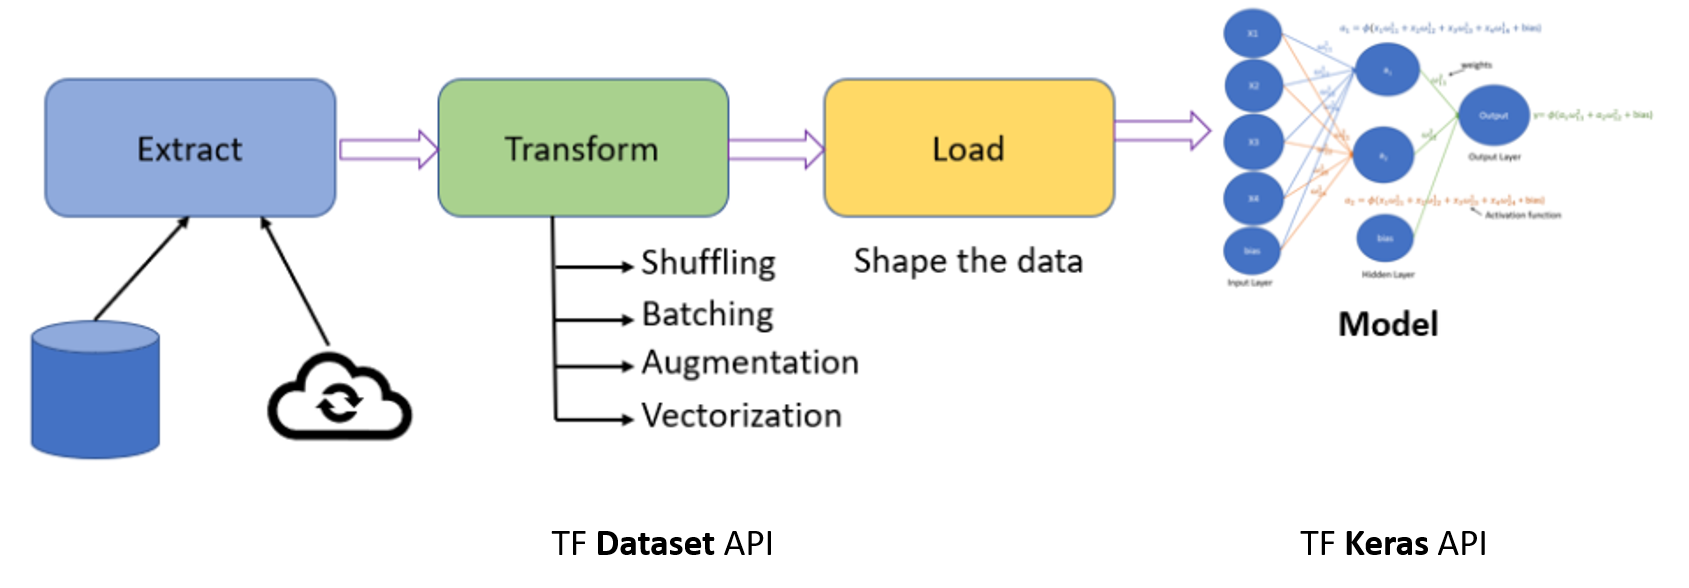

In [ ]:
# traindf = traindf.drop(['trip_start_month', 'trip_start_day', 'trip_start_hour'], axis=1)
# evaldf = evaldf.drop(['trip_start_month', 'trip_start_day', 'trip_start_hour'], axis=1)
traindf.to_csv("/root/new-york-city-taxi/train_split.csv", index=False)
evaldf.to_csv("/root/new-york-city-taxi/test_split.csv", index=False,)

In [ ]:
evaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2255 entries, 16 to 14997
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        2255 non-null   float64
 1   pickup_longitude   2255 non-null   float64
 2   pickup_latitude    2255 non-null   float64
 3   dropoff_longitude  2255 non-null   float64
 4   dropoff_latitude   2255 non-null   float64
 5   trip_start_month   2255 non-null   object 
 6   trip_start_hour    2255 non-null   object 
 7   trip_start_day     2255 non-null   object 
 8   distance           2255 non-null   float64
dtypes: float64(6), object(3)
memory usage: 176.2+ KB


In [ ]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12745 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        12745 non-null  float64
 1   pickup_longitude   12745 non-null  float64
 2   pickup_latitude    12745 non-null  float64
 3   dropoff_longitude  12745 non-null  float64
 4   dropoff_latitude   12745 non-null  float64
 5   trip_start_month   12745 non-null  object 
 6   trip_start_hour    12745 non-null  object 
 7   trip_start_day     12745 non-null  object 
 8   distance           12745 non-null  float64
dtypes: float64(6), object(3)
memory usage: 1.6+ MB


In [ ]:
###############################
##Feature engineering functions
def feature_engg_features(features):
  #Add new features
  print(features)
  diff_lat = tf.math.subtract(features['pickup_latitude'], features['dropoff_latitude'])
  diff_long = tf.math.subtract(features['pickup_longitude'], features['dropoff_longitude'])
  total = tf.math.add(tf.math.multiply(diff_lat, diff_lat),  tf.math.multiply(diff_long, diff_long))
  features['distance'] = tf.math.multiply(total, 0.5)

  return(features)

#To be called from TF
def feature_engg(features, label):
  #Add new features
  features = feature_engg_features(features)

  return(features, label)  

In [ ]:
CSV_COLUMNS

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance'],
      dtype='object')

In [ ]:
###############################
###Data Input pipeline function

# Determine CSV, label, and key columns
#Columns in training sheet -> Can have extra columns too
CSV_COLUMNS = traindf.columns
LABEL_COLUMN = 'fare_amount'

# Set default values for each CSV column( Including Y column )
# DEFAULTS = [[0.0], [']1'], ['1'],['1'],[0.0],[0.0],[0.0],[0.0]]

def make_input_fn(filename, mode, vnum_epochs = None, batch_size = 512):
    def _input_fn(v_test=False):     
        # Create list of files that match pattern
        # file_list = tf.io.gfile.glob(filename)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
        else:
            num_epochs = 1 # end-of-input after this        
        
        # Create dataset from file list
        print("filename")
        dataset = tf.compat.v1.data.experimental.make_csv_dataset(filename,
                                                   batch_size=batch_size,
                                                   column_names=CSV_COLUMNS,
                                                  #  column_defaults=DEFAULTS,
                                                   label_name=LABEL_COLUMN,
                                                   num_epochs = num_epochs,
                                                   num_parallel_reads=30)
        print(CSV_COLUMNS)
        print(LABEL_COLUMN)
        
        dataset = dataset.prefetch(buffer_size = batch_size)
        # dataset = dataset.features['trip_start_month'].astype("str")
        # dataset = dataset['trip_start_day'].astype("str")
        # dataset = dataset['trip_start_hour'].astype("str")

        #Feature engineering
        dataset = dataset.map(feature_engg)

        if mode == tf.estimator.ModeKeys.TRAIN:
            num_epochs = vnum_epochs # indefinitely
            dataset = dataset.shuffle(buffer_size = batch_size)
        else:
            num_epochs = 1 # end-of-input after this

        dataset = dataset.repeat(num_epochs)       
        
        #Begins - Uncomment for testing only -----------------------------------------------------<
        if v_test == True:
          print(next(dataset.__iter__()))
          
        #End - Uncomment for testing only -----------------------------------------------------<
        return dataset
    return _input_fn

In [ ]:
#Test dataset read + Feat Engg function's - output's CSV + Feature engg columns
eval_file = "/root/new-york-city-taxi/test_split.csv"
fn_d = make_input_fn(filename = eval_file,
                    mode = tf.estimator.ModeKeys.EVAL,
                    # vnum_epochs = 1,
                    batch_size = 10)

fn_d(v_test=True)

filename
Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_start_month',
       'trip_start_hour', 'trip_start_day', 'distance'],
      dtype='object')
fare_amount
OrderedDict([('pickup_longitude', <tf.Tensor 'args_4:0' shape=(None,) dtype=float32>), ('pickup_latitude', <tf.Tensor 'args_3:0' shape=(None,) dtype=float32>), ('dropoff_longitude', <tf.Tensor 'args_2:0' shape=(None,) dtype=float32>), ('dropoff_latitude', <tf.Tensor 'args_1:0' shape=(None,) dtype=float32>), ('trip_start_month', <tf.Tensor 'args_7:0' shape=(None,) dtype=int32>), ('trip_start_hour', <tf.Tensor 'args_6:0' shape=(None,) dtype=int32>), ('trip_start_day', <tf.Tensor 'args_5:0' shape=(None,) dtype=int32>), ('distance', <tf.Tensor 'args_0:0' shape=(None,) dtype=float32>)])
(OrderedDict([('pickup_longitude', <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-73.96789, -73.98841, -73.98567, -73.87091, -73.98322, -73.965  ,
       -73.95131, -73.98161

<DatasetV1Adapter shapes: (OrderedDict([(pickup_longitude, (None,)), (pickup_latitude, (None,)), (dropoff_longitude, (None,)), (dropoff_latitude, (None,)), (trip_start_month, (None,)), (trip_start_hour, (None,)), (trip_start_day, (None,)), (distance, (None,))]), (None,)), types: (OrderedDict([(pickup_longitude, tf.float32), (pickup_latitude, tf.float32), (dropoff_longitude, tf.float32), (dropoff_latitude, tf.float32), (trip_start_month, tf.int32), (trip_start_hour, tf.int32), (trip_start_day, tf.int32), (distance, tf.float32)]), tf.float32)>

In [ ]:
# Define feature columns(Including feature engineered ones )
# These are the features which come from the TF Data pipeline
def create_feature_cols():
    #Keras format features
    k_month = tf.keras.Input(name='trip_start_month', shape=(1,), dtype=tf.string)
    k_hour  = tf.keras.Input(name='trip_start_hour', shape=(1,), dtype=tf.string)
    k_day  = tf.keras.Input(name='trip_start_day', shape=(1,), dtype=tf.string)
    k_picklat  = tf.keras.Input(name='pickup_latitude', shape=(1,), dtype=tf.float32)
    k_picklon  = tf.keras.Input(name='pickup_longitude', shape=(1,), dtype=tf.float32)
    k_droplat  = tf.keras.Input(name='dropoff_latitude', shape=(1,), dtype=tf.float32)
    k_droplon  = tf.keras.Input(name='dropoff_longitude', shape=(1,), dtype=tf.float32)
    k_distance  = tf.keras.Input(name='distance', shape=(1,), dtype=tf.float32)
    keras_dict_input = {'trip_start_month': k_month, 'trip_start_hour': k_hour, 'trip_start_day' : k_day,
                        'pickup_latitude': k_picklat, 'pickup_longitude': k_picklon,
                        'dropoff_latitude': k_droplat, 'dropoff_longitude': k_droplon, 'distance' : k_distance
                        }

    return({'K' : keras_dict_input})

create_feature_cols()

{'K': {'distance': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'distance')>,
  'dropoff_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_latitude')>,
  'dropoff_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dropoff_longitude')>,
  'pickup_latitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_latitude')>,
  'pickup_longitude': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'pickup_longitude')>,
  'trip_start_day': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_day')>,
  'trip_start_hour': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_hour')>,
  'trip_start_month': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'trip_start_month')>}}

### **Model - Training pipeline**

We are going to build a Deep Neural Network which will comprise of following in-model feature engineering techniques:
1. One-Hot encode all categorical attributes
2. Feature cross: Cross-join categorical attributes( ex: Lat cross Lon )
3. Network architecture: Wide( Categorical  ) and Deep( Continuous features )
4. Regularization( Overfit prevention ): L2
5. Uses GPU / TPU as distribution infra

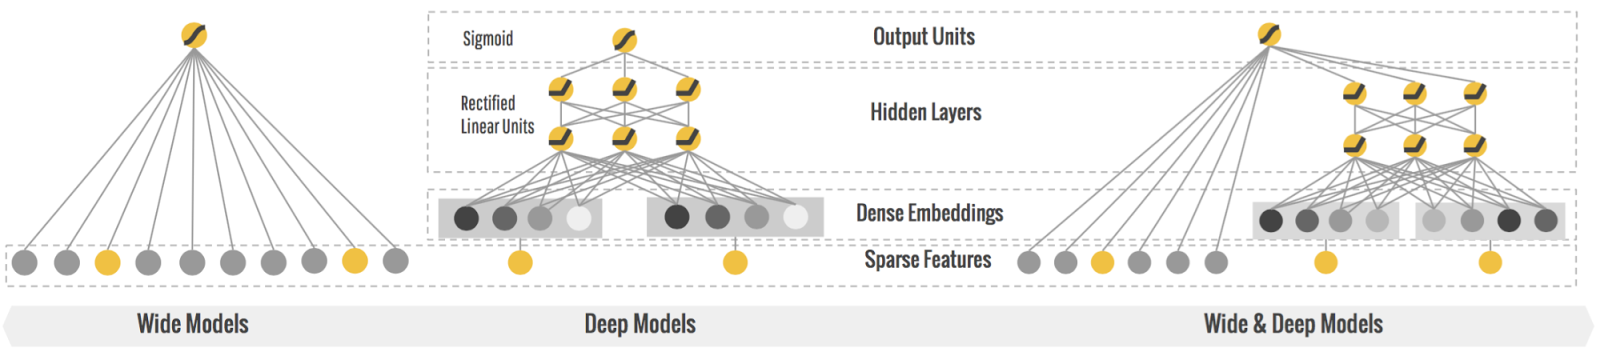

In [ ]:
#Create model
params_default = {
    'lr' : 0.001,
    'beta_1' : 0.99,
    'beta_2' : 0.999,
    'epsilon' : 1e-08,
    'decay' : 0.01,
    'hidden_layers' : 1
}

##Feature Engineering
# def featengg_funcs(inp):
#     #Add all calculations, pass out as concatenate
#     vpatd_squared = inp[1] * inp[1]
#     vpatd_neg = -1 * inp[1]

#     return keras.layers.concatenate([vpatd_squared, vpatd_neg], axis = 1)

def create_keras_model(params, feature_cols):
    METRICS = [
            keras.metrics.RootMeanSquaredError(name='rmse')
    ]

    #Input layers
    input_feats = []
    for inp in feature_cols['K'].keys():
      input_feats.append(feature_cols['K'][inp])

    ##Input processing
    ##https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
    ##https://github.com/tensorflow/community/blob/master/rfcs/20191212-keras-categorical-inputs.md

    ##Handle categorical attributes( One-hot encoding )
    cat_day = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7'], mask_token=None)(feature_cols['K']['trip_start_day'])
    cat_day = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=7)(cat_day)

    cat_hour = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12','13','14','15','16',
                                                                                      '17','18','19','20','21','22','23','0'
                                                                                      ], mask_token=None)(feature_cols['K']['trip_start_hour'])
    cat_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=24)(cat_hour)

    cat_month = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=['1','2','3','4','5','6','7','8'
                                                                                      '9','10','11','12'], mask_token=None)(feature_cols['K']['trip_start_month'])
    cat_month = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=12)(cat_month)

    # cat_company = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=df['company'].unique(), mask_token=None)(feature_cols['K']['company'])
    # cat_company = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=len(df['company'].unique()))(cat_company)

    ##Binning
    bins_pickup_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['pickup_latitude'])
    cat_pickup_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_pickup_lat)

    bins_pickup_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['pickup_longitude'])
    cat_pickup_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_pickup_lon)

    bins_drop_lat = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lat)(feature_cols['K']['dropoff_latitude'])
    cat_drop_lat = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lat)+1)(bins_drop_lat)

    bins_drop_lon = tf.keras.layers.experimental.preprocessing.Discretization(bins = bins_lon)(feature_cols['K']['dropoff_longitude'])
    cat_drop_lon = tf.keras.layers.experimental.preprocessing.CategoryEncoding(len(bins_lon)+1)(bins_drop_lon)

    ##Categorical cross
    cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_day, cat_hour])
    hash_cross_day_hour = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=24 * 7)(cross_day_hour)
    cat_cross_day_hour = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = 24* 7)(hash_cross_day_hour)

    cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_pickup_lat, cat_pickup_lon])
    hash_cross_pick_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_pick_lon_lat)

    cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.CategoryCrossing()([cat_drop_lat, cat_drop_lon])
    hash_cross_drop_lon_lat = tf.keras.layers.experimental.preprocessing.Hashing(num_bins=(len(bins_lat) + 1) ** 2)(cross_drop_lon_lat)

    # Cross to embedding
    embed_cross_pick_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_pick_lon_lat)
    embed_cross_pick_lon_lat = tf.reduce_sum(embed_cross_pick_lon_lat, axis=-2)

    embed_cross_drop_lon_lat = tf.keras.layers.Embedding(((len(bins_lat) + 1) ** 2), 4)(hash_cross_drop_lon_lat)
    embed_cross_drop_lon_lat = tf.reduce_sum(embed_cross_drop_lon_lat, axis=-2)

    # Also pass time attributes as Deep signal( Cast to integer )
    # int_trip_start_day = tf.strings.to_number(feature_cols['K']['trip_start_day'], tf.float32)
    # print("-------------")
    # print(int_trip_start_day)
    # print("-------------")
    # int_trip_start_hour = tf.strings.to_number(feature_cols['K']['trip_start_hour'], tf.float32)
    # int_trip_start_month = tf.strings.to_number(feature_cols['K']['trip_start_month'], tf.float32)
    # int_trip_start_day = tf.dtypes.cast(feature_cols['K']['trip_start_day'], tf.float32)
    # int_trip_start_hour = tf.dtypes.cast(feature_cols['K']['trip_start_hour'], tf.float32)
    # int_trip_start_month = tf.dtypes.cast(feature_cols['K']['trip_start_month'], tf.float32)
    

    #Add feature engineered columns - LAMBDA layer

    ###Create MODEL
    ####Concatenate all features( Numerical input )
    x_input_numeric = tf.keras.layers.concatenate([
                    feature_cols['K']['pickup_latitude'], feature_cols['K']['pickup_longitude'],
                    feature_cols['K']['dropoff_latitude'], feature_cols['K']['dropoff_longitude'],
                    feature_cols['K']['distance'], embed_cross_pick_lon_lat, embed_cross_drop_lon_lat
                    
                    # ,
                    # int_trip_start_day, int_trip_start_hour, int_trip_start_month
                    ])

    #DEEP - This Dense layer connects to input layer - Numeric Data
    x_numeric = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_numeric)
    x_numeric = tf.keras.layers.BatchNormalization()(x_numeric)

    ####Concatenate all Categorical features( Categorical converted )
    x_input_categ = tf.keras.layers.concatenate([
                    # cat_month, cat_cross_day_hour, 
                    cat_pickup_lat, cat_pickup_lon,
                    cat_drop_lat, cat_drop_lon
                    ])
    
    #WIDE - This Dense layer connects to input layer - Categorical Data
    x_categ = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform")(x_input_categ)

    ####Concatenate both Wide and Deep layers
    x = tf.keras.layers.concatenate([x_categ, x_numeric])

    for l_ in range(params['hidden_layers']):
        x = tf.keras.layers.Dense(32, activation='relu', kernel_initializer="he_uniform",
                                  activity_regularizer=tf.keras.regularizers.l2(0.00001))(x)
        x = tf.keras.layers.BatchNormalization()(x)

    #Final Layer
    out = tf.keras.layers.Dense(1, activation='relu')(x)
    model = tf.keras.Model(input_feats, out)

    #Set optimizer
    opt = tf.keras.optimizers.Adam(lr= params['lr'], beta_1=params['beta_1'], 
                                        beta_2=params['beta_2'], epsilon=params['epsilon'])

    #Compile model
    model.compile(loss='mean_squared_error',  optimizer=opt, metrics = METRICS)

    #Print Summary
    print(model.summary())
    return model

In [ ]:
def keras_train_and_evaluate(model, train_dataset, validation_dataset, epochs=100):
  #Add callbacks
  reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=5, min_lr=0.00001, verbose = 1)
  
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

  #Train and Evaluate
  out = model.fit(train_dataset, 
                  validation_data = validation_dataset,
                  epochs=epochs,
                  # validation_steps = 3,   ###Keep this none for running evaluation on full EVAL data every epoch
                  steps_per_epoch = 100,   ###Has to be passed - Cant help it :) [ Number of batches per epoch ]
                  callbacks=[reduce_lr, #modelsave_callback, #tensorboard_callback, 
                             keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=True)]
                  )

filename
Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_start_month',
       'trip_start_hour', 'trip_start_day', 'distance'],
      dtype='object')
fare_amount
OrderedDict([('pickup_longitude', <tf.Tensor 'args_4:0' shape=(512,) dtype=float32>), ('pickup_latitude', <tf.Tensor 'args_3:0' shape=(512,) dtype=float32>), ('dropoff_longitude', <tf.Tensor 'args_2:0' shape=(512,) dtype=float32>), ('dropoff_latitude', <tf.Tensor 'args_1:0' shape=(512,) dtype=float32>), ('trip_start_month', <tf.Tensor 'args_7:0' shape=(512,) dtype=int32>), ('trip_start_hour', <tf.Tensor 'args_6:0' shape=(512,) dtype=int32>), ('trip_start_day', <tf.Tensor 'args_5:0' shape=(512,) dtype=int32>), ('distance', <tf.Tensor 'args_0:0' shape=(512,) dtype=float32>)])
filename
Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'trip_start_month',
       'trip_start_hour', 'trip_start_day', 'distanc

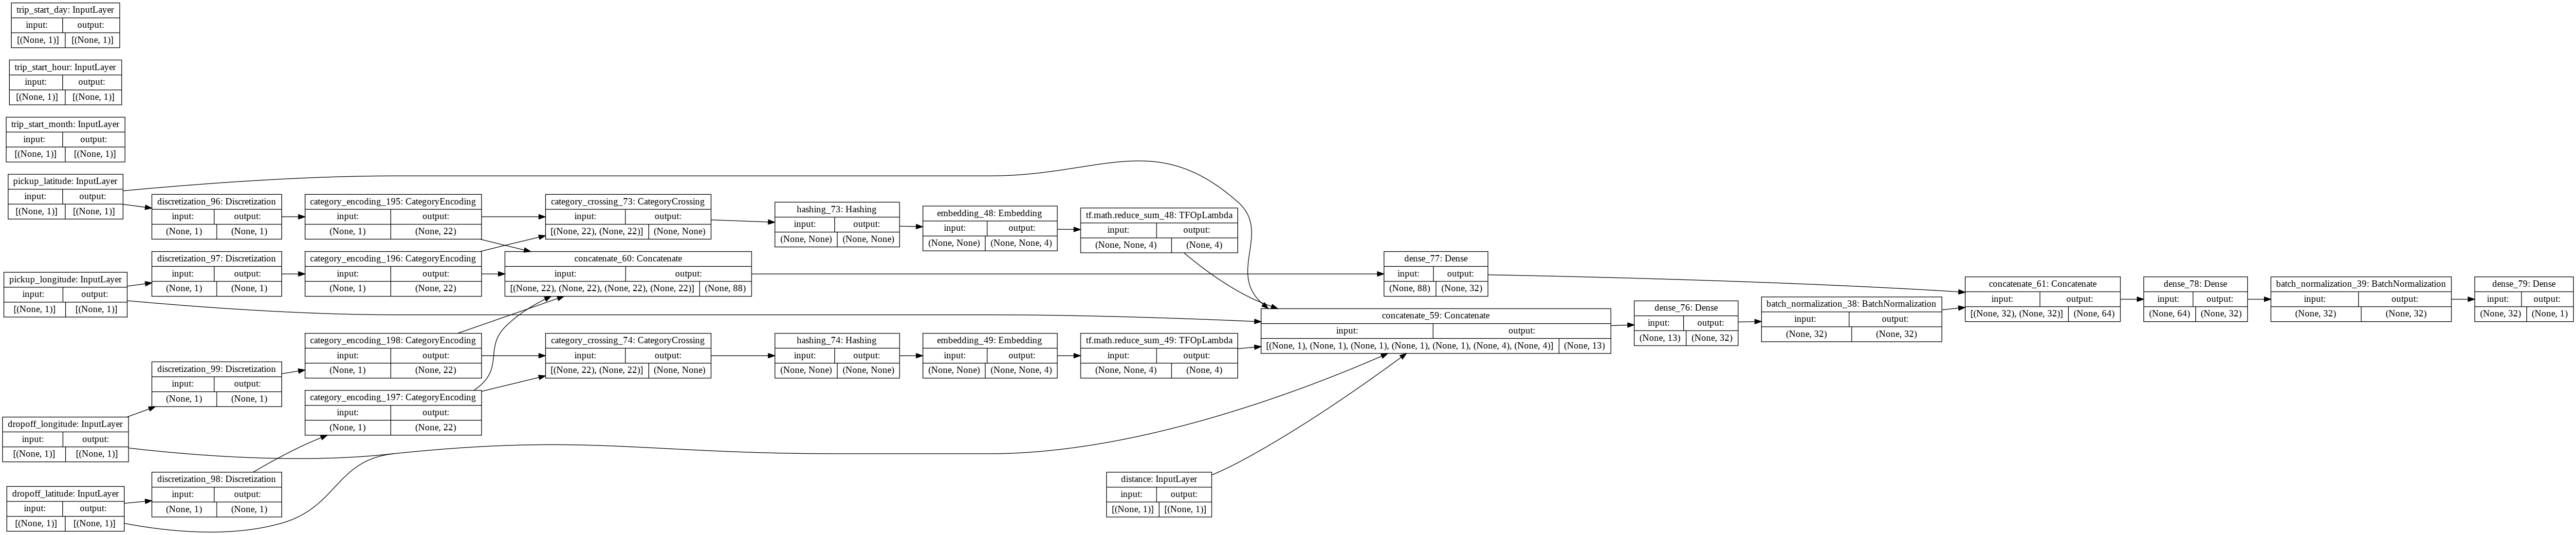

In [ ]:
#Create dataset input functions
train_dataset = make_input_fn(filename = '/root/new-york-city-taxi/train_split.csv', mode = tf.estimator.ModeKeys.TRAIN)()

validation_dataset = make_input_fn(filename = '/root/new-york-city-taxi/test_split.csv',
                    mode = tf.estimator.ModeKeys.EVAL)()

m_ = create_keras_model(params = params_default, feature_cols = create_feature_cols())
tf.keras.utils.plot_model(m_, show_shapes=True, rankdir="LR")

In [ ]:
# !rm -rf "./logs"
# %tensorboard --logdir "./logs"

keras_train_and_evaluate(m_, train_dataset, validation_dataset, 1)

100/100 [==============================] - 66s 622ms/step - loss: 193.6791 - rmse: 13.9091 - val_loss: 509.7314 - val_rmse: 22.5772


### **Serving: Export model**

In [ ]:
# ## Prediction directly using model's instance
# ## BUT HERE ALL FEATURES HAVE TO BE PASSED, EVEN THE Calculated ones
data = tf.data.Dataset.from_tensor_slices({'dropoff_latitude': [[41.920452]],
                         'dropoff_longitude': [[-87.679955]],
                         'pickup_latitude': [[41.952823]],
                         'pickup_longitude': [[-87.653244]],
                         'trip_start_day': [["1"]],
                         'trip_start_hour': [["5"]],
                         'trip_start_month': [["6"]],
                         'distance':[[0.04196861]]})

m_.predict(data)

array([[44.503822]], dtype=float32)

In [ ]:
@tf.function
def serving(dropoff_latitude, dropoff_longitude, pickup_latitude, pickup_longitude, trip_start_day, trip_start_hour, trip_start_month):
    ##Feature engineering( calculate distance )
    distance = tf.cast( tf.sqrt((tf.abs(dropoff_latitude - pickup_latitude))**2 + (tf.abs(dropoff_longitude - pickup_longitude))**2), tf.float32)

    payload = {
        'dropoff_latitude': dropoff_latitude,
        'dropoff_longitude': dropoff_longitude,
        'pickup_latitude': pickup_latitude,
        'pickup_longitude': pickup_longitude,
        'trip_start_day': trip_start_day,
        'trip_start_hour': trip_start_hour,
        'trip_start_month': trip_start_month,
        'distance': distance
    }
    
    ## Predict
    ##IF THERE IS AN ERROR IN NUMBER OF PARAMS PASSED HERE OR DATA TYPE THEN IT GIVES ERROR, "COULDN'T COMPUTE OUTPUT TENSOR"
    predictions = m_(payload)
    return predictions

serving = serving.get_concrete_function(trip_start_day=tf.TensorSpec([None,], dtype= tf.string, name='trip_start_day'), 
                                        trip_start_hour=tf.TensorSpec([None,], dtype= tf.string, name='trip_start_hour'),
                                        trip_start_month=tf.TensorSpec([None], dtype= tf.string, name='trip_start_month'), 
                                        dropoff_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_latitude'),
                                        dropoff_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='dropoff_longitude'), 
                                        pickup_latitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_latitude'),
                                        pickup_longitude=tf.TensorSpec([None,], dtype= tf.float32, name='pickup_longitude')
                                        )

version = "1"  #{'serving_default': call_output}
tf.saved_model.save(
    m_,
    "./exported_model/" + version,
    signatures=serving
) 

# tf.saved_model.save(
#     m_,
#     "./exported_model/" + version,
#     signatures={'serving_default': serving}
# ) 

INFO:tensorflow:Assets written to: ./exported_model/1/assets


In [ ]:
# !zip -r /content/model.zip /content/exported_model/1
!tar -cvf /content/model.tar /content/exported_model/1/

tar: Removing leading `/' from member names
tar: /content/exported_model/1: Cannot stat: No such file or directory
tar: Exiting with failure status due to previous errors


In [ ]:
##Check signature
!saved_model_cli show --dir "./exported_model/1" --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['dropoff_latitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_dropoff_latitude:0
    inputs['dropoff_longitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_dropoff_longitude:0
    inputs['pickup_latitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: serving_default_pickup_latitude:0
    inputs['pickup_longitude'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
 

In [ ]:
#LOCAL: Predict using Keras prediction function
saved_mod = tf.saved_model.load("./exported_model/" + version)

#Get prediction function from serving
f = saved_mod.signatures['serving_default']

#Run prediction function from serving
f(dropoff_latitude=tf.convert_to_tensor([41.920452]), dropoff_longitude = tf.convert_to_tensor([-87.679955]), pickup_latitude = tf.convert_to_tensor([41.952823]), 
  pickup_longitude =tf.convert_to_tensor([-87.653244]), trip_start_day=tf.convert_to_tensor(["1"]), trip_start_hour=tf.convert_to_tensor(["5"]),
  trip_start_month=tf.convert_to_tensor(["6"]))

{'output_0': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[44.503822]], dtype=float32)>}

In [ ]:
###Install TF Model server

# This is the same as you would do from your command line, but without the [arch=amd64], and no sudo
# You would instead do:
# echo "deb [arch=amd64] http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | sudo tee /etc/apt/sources.list.d/tensorflow-serving.list && \
# curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | sudo apt-key add -

!apt-get remove tensorflow-model-server
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  tensorflow-model-server
0 upgraded, 0 newly installed, 1 to remove and 36 not upgraded.
After this operation, 0 B of additional disk space will be used.
(Reading database ... 160691 files and directories currently installed.)
Removing tensorflow-model-server (2.5.0) ...
deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  52553      0 --:--:-- --:--:-- --:--:-- 52553
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 https://clou

In [ ]:
###Start Tensorflow server
# %%bash --bg 
# export TF_CPP_MIN_VLOG_LEVEL=0

%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8505 \
  --model_name=model \
  --model_base_path="/content/exported_model" >server.log 2>&1

Starting job # 3 in a separate thread.


In [ ]:
!tail server.log

2021-04-25 07:20:12.261633: E tensorflow_serving/sources/storage_path/file_system_storage_path_source.cc:365] FileSystemStoragePathSource encountered a filesystem access error: Could not find base path /content/exported_model for servable model with error Not found: /content/exported_model not found
2021-04-25 07:20:13.261734: E tensorflow_serving/sources/storage_path/file_system_storage_path_source.cc:365] FileSystemStoragePathSource encountered a filesystem access error: Could not find base path /content/exported_model for servable model with error Not found: /content/exported_model not found
2021-04-25 07:20:14.261836: E tensorflow_serving/sources/storage_path/file_system_storage_path_source.cc:365] FileSystemStoragePathSource encountered a filesystem access error: Could not find base path /content/exported_model for servable model with error Not found: /content/exported_model not found
2021-04-25 07:20:15.262009: E tensorflow_serving/sources/storage_path/file_system_storage_path_so

In [ ]:
import json
import requests

#Create payload
data_py = {"instances":[{'dropoff_latitude': [41.920452],
                         'dropoff_longitude': [-87.679955],
                         'pickup_latitude': [41.952823],
                         'pickup_longitude': [-87.653244]
                         ,
                         'trip_start_day': ["1"],
                         'trip_start_hour': ["5"],
                         'trip_start_month': ["6"]
                         }]}

data = json.dumps(data_py)
print("payload: ", data)

#Run request on TMS
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8505/v1/models/model:predict', data=data, headers=headers)
json_response.text

payload:  {"instances": [{"dropoff_latitude": [41.920452], "dropoff_longitude": [-87.679955], "pickup_latitude": [41.952823], "pickup_longitude": [-87.653244], "trip_start_day": ["1"], "trip_start_hour": ["5"], "trip_start_month": ["6"]}]}


ConnectionError: ignored